In [1]:
import joblib
import numpy as np
import os

import jax.numpy as jnp
import jax

import mujoco
from mujoco import mjx
from pathlib import Path
from tasks.cart_pole_unconstrained import CartPoleUnconstrained
from tasks.pusht_unconstrained import PushTUnconstrained
from tasks.pendulum_unconstrained import PendulumUnconstrained
from tasks.double_cart_pole_unconstrained import DoubleCartPoleUnconstrained

from traj_opt_helper import TrajectoryOptimizer
from algorithm import create_algorithm
from task import create_task

# # Prevent JAX from pre-allocating all GPU memory
# os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = 'false'
# os.environ['XLA_PYTHON_CLIENT_ALLOCATOR'] = 'platform'
# os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION'] = '0.7'

# jax.config.update("jax_platform_name", "cpu")  

# os.environ['XLA_FLAGS'] = (
#     '--xla_gpu_deterministic_ops=true '
#     '--xla_gpu_autotune_level=0' 
# )

print(jax.devices()) 

[CudaDevice(id=0)]


/home/rooh/miniconda3/envs/hydrax/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Trajectory Optimization Benchmarks

This notebook helps you run trajectory-optimization benchmarks on a robotics problem and visualize the solution.


**Supported sampling-based algorithms:**
- MPPI  
- MPPI-CMA  
- Predictive Sampling  
- CMA-ES  
- Randomized Smoothing  

**Supported tasks:**

*Easy tasks*:
- Cartpole  
- Inverted Pendulum  
- Double Cartpole

*Hard tasks (contact-rich)*:
- PushT  
- Humanoid  
- Cube Rotation  


# Define you algorithm, task, and parameters

In [ ]:

algorithms = ["MPPI", "MPPI_CMA lr=(1.0, 0.1)"] #["MPPI", "MPPI lr=0.1", "MPPI_CMA lr=(1.0, 0.1)", "MPPI_CMA lr=(0.1, 0.1)", "MPPI_CMA_BD lr=(1.0, 0.1)", "MPPI_CMA_BD lr=(0.1, 0.1)", "PredictiveSampling",  "CMA-ES", "RandomizedSmoothing lr=0.1",] # MPPI, MPPI_CMA, RandomizedSmoothing, PredictiveSampling, CMA-ES
task_name = "Walker" # "CartPole", "InvertedPendulum", "DoubleCartPole", "PushT", "CubeRotation", "Humanoid"
# Parameters
num_trails = 6
max_iterations = 100
num_samples = 2048
sigma_init = 0.3
temperature = 0.1
horizon = 1.0 # Suggested horizon: 1.0 (for humanoid); 2.0 (for others)

# Set this to (horizon/mj_model.opt.timestep) equals to no spline interpolation
num_knots = 10 # Suggested num_knots: 200 (for easy tasks: no interpolation);  1 knot  out of 5 ctrl steps (for hard tasks)
spline = "zero" # "zero", "linear", "cubic"
run_benchmark = True # running benchmarks or not


# Load task (add your own task in task.py)

In [3]:
task, mj_model, mj_data = create_task(task_name=task_name)
# Python
if task.model.opt.disableflags & mujoco.mjtDisableBit.mjDSBL_WARMSTART:
    print("Warmstart is DISABLED")
else:
    print("Warmstart is ENABLED")

Warmstart is DISABLED


# (Optionally) time the algorithms

In [4]:
# from profiler import time_profile, plot_results

# algorithm_names = ["MPPI", "MPPI_CMA"]
# task_names = ["CartPole", "PushT", "DoubleCartPole", "Humanoid"]

# # Profile multiple controllers
# results = []
# for algorithm_name in algorithm_names:
#     for task_name in task_names:
#         task, mj_model_profile, mj_data_profile = create_task(task_name)
#         controller = create_algorithm(name = algorithm_name,
#                                 task = task,
#                                 num_samples = num_samples,
#                                 horizon = horizon,
#                                 num_knots = num_knots,
#                                 spline = spline,
#                                 temperature = temperature,
#                                 noise = sigma_init)
#         result = time_profile(controller, mj_model_profile, mj_data_profile)
#         results.append(result)

# # Plot all results
# plot_results(results)

# Run benchmarks
* The control trajectory of the best solution will be plotted

In [ ]:
if run_benchmark == True:
    for algorithm in algorithms:

        alg = create_algorithm(name = algorithm, 
                            task = task,
                            num_samples = num_samples,
                            horizon = horizon,
                            num_knots = num_knots,
                            spline = spline,
                            temperature = temperature,
                            noise = sigma_init)

        to = TrajectoryOptimizer(algorithm, alg, mj_model, mj_data)
        to.trails(max_iteration=max_iterations, num_trails = num_trails, save_npz=True)

Trajectory Optimization with 10 steps over a 1.0 second horizon.
task.dt:0.02; controller.dt:0.02; task.model.opt.timestep: 0.02; task.mj_model.opt.timestep: 0.02; simulator mj_model.opt.timestep: 0.02
Controller dt: 0.02
Simulator dt: 0.02
Jitting the controller...


# Generate convergence plot

┌──────────────────────────────────────────────┐
│ Visualising results…                        │
└──────────────────────────────────────────────┘
Figure saved to: /home/rooh/workspace/rs-rl/traj_opt/figures/HumanoidMocap/HumanoidMocap_Convergence.pdf


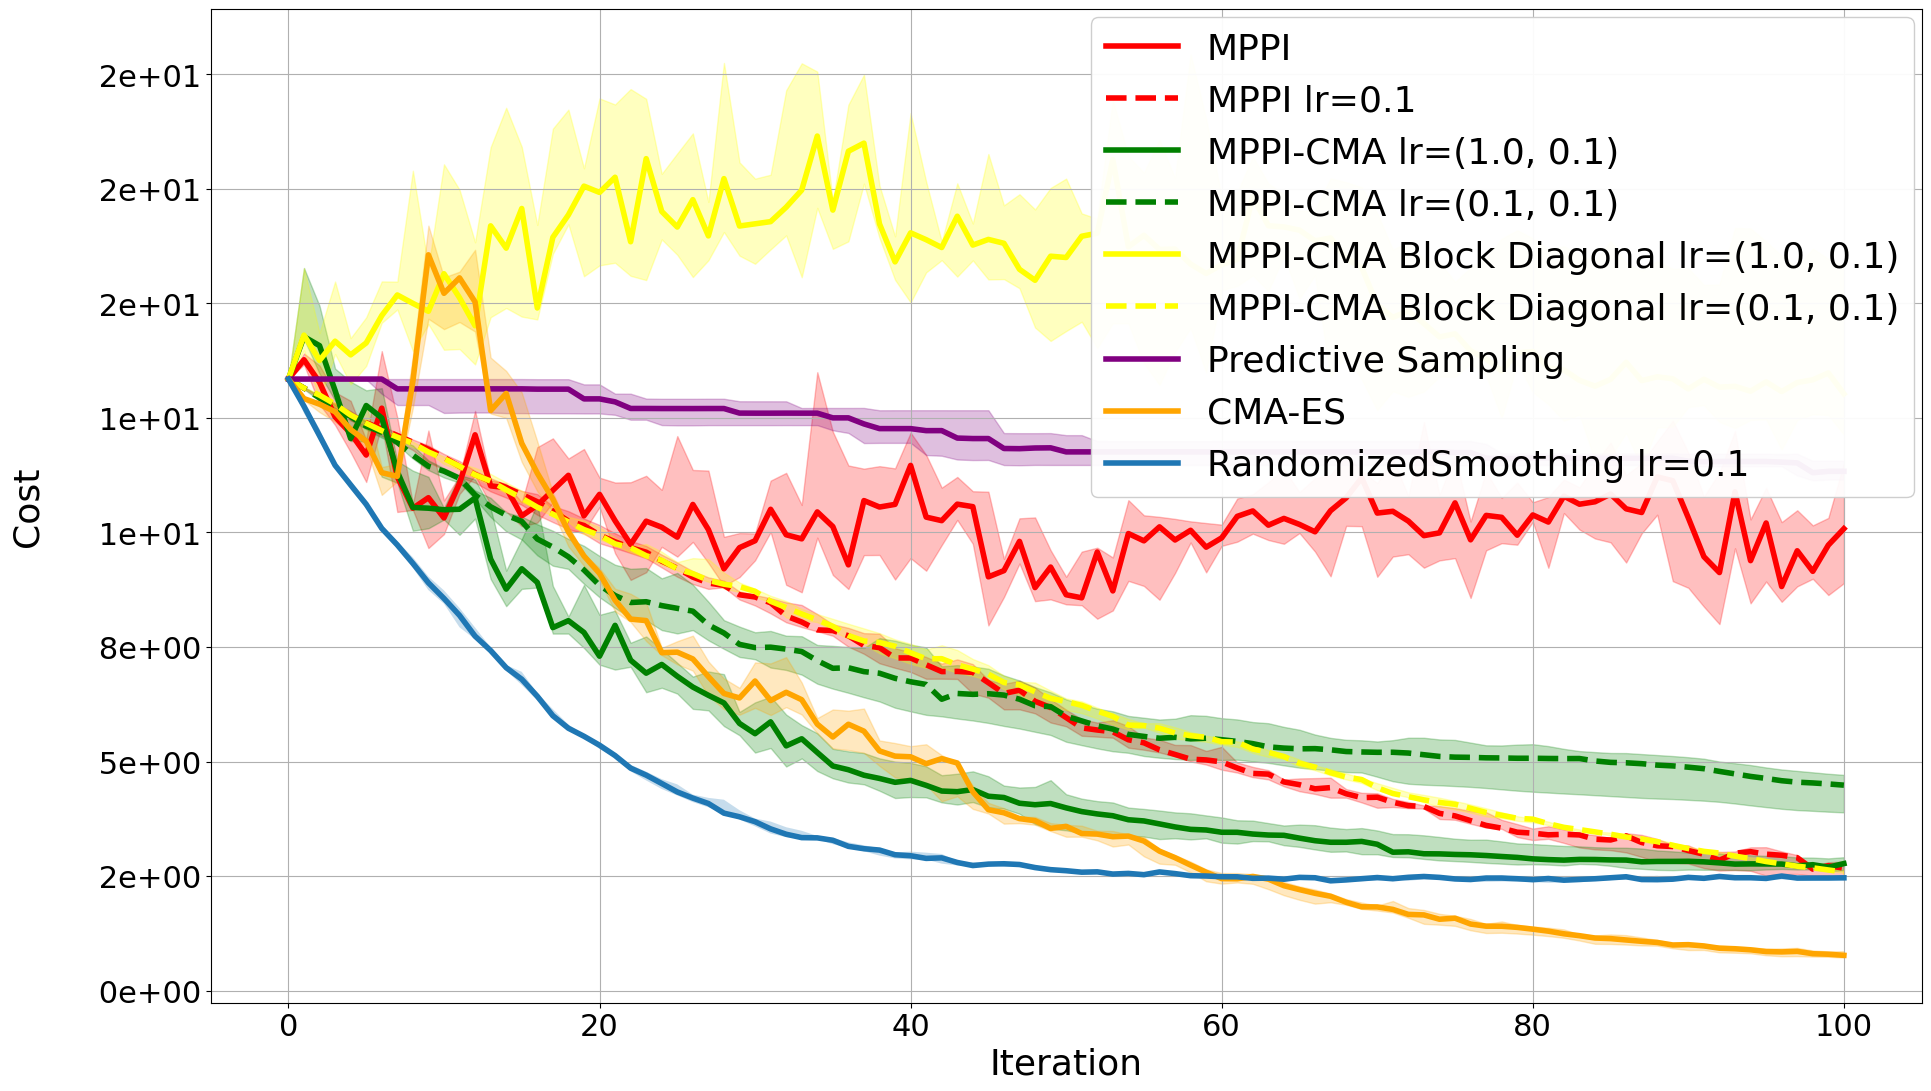

In [ ]:
from plot import visualize_optimization_results

details = visualize_optimization_results(task, algorithms)

┌──────────────────────────────────────────────┐
│        Visualising results…                  │
└──────────────────────────────────────────────┘
Results directory: /home/rooh/workspace/rs-rl/traj_opt/data/HumanoidMocap


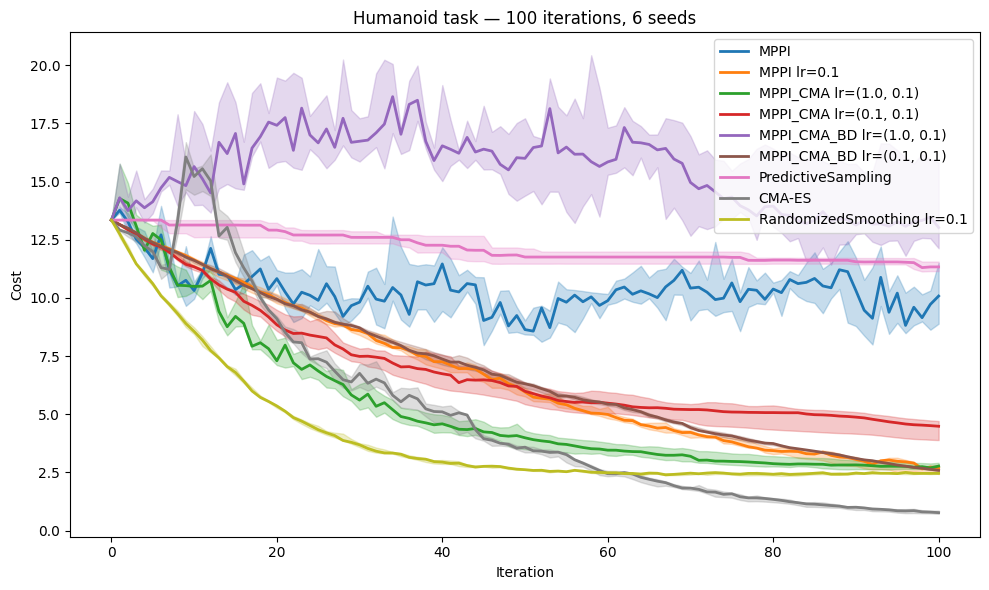

In [ ]:
import matplotlib.pyplot as plt

print("┌──────────────────────────────────────────────┐")
print("│        Visualising results…                  │")
print("└──────────────────────────────────────────────┘")

results_dir = Path(TrajectoryOptimizer.get_path(task))
print(f"Results directory: {results_dir}")

methods = {}                                   # keep raw algorithm names

for alg in algorithms:
    f = results_dir / f"{alg}_trails_costs.pkl"
    try:
        arr = joblib.load(f)                   # shape (n_trials, n_iters)
        methods[alg] = np.asarray(arr)
    except FileNotFoundError:
        print(f"[warn] {f.name} not found; skipping.")

if not methods:
    raise RuntimeError("No cost files loaded — nothing to plot.")

iters  = np.arange(next(iter(methods.values())).shape[1])
colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]

plt.figure(figsize=(10, 6))
for (name, costs), color in zip(methods.items(), colors):
    q25, med, q75 = np.quantile(costs, [0.25, 0.5, 0.75], axis=0)
    plt.plot(iters, med, lw=2, label=name, color=color)
    plt.fill_between(iters, q25, q75, color=color, alpha=0.25)

plt.title(f"{task_name.capitalize()} task — {costs.shape[1]-1} iterations, {num_trails} seeds")
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.legend()
plt.tight_layout()
plt.show()

# Visualize solution
-In simulator or as a gif

In [ ]:
# try:
#     to.visualize_rollout(task, controller_name="MPPI-CMA")
# except NameError:
#     pass


GIF saved to: /home/rooh/workspace/rs-rl/traj_opt/data/HumanoidMocap/MPPI_CMA lr=(1.0, 0.1).gif


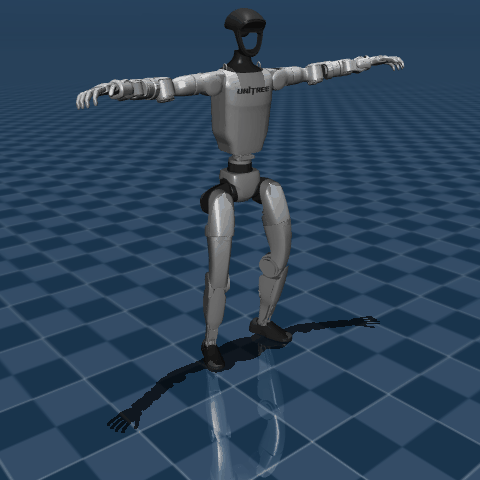

In [ ]:
to.visualize_rollout_gif(task, "MPPI_CMA lr=(1.0, 0.1)", fps=30)

GIF saved to: /home/rooh/workspace/rs-rl/traj_opt/data/HumanoidMocap/CMA-ES.gif


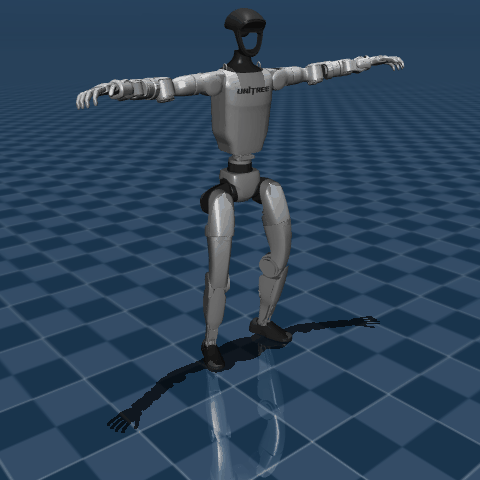

In [ ]:
to.visualize_rollout_gif(task, "CMA-ES", fps=30)
